In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from PIL import Image
import tensorflow as tf
import cv2
from tf_explain.core.grad_cam import GradCAM
import os
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
# # Enable memory growth for the GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)

## 1) The Dataset

- Assuming you have a classification problem, is it binary, multi-class or multi-label?
  - I have a multi-class classification problem

- How many classes?
  - I have 6 classes named Cheetah, Fox, Hyena, Lion, Tiger and Wolf

- How many images per class?
  - Cheetah has 319 images, Fox has 250 images, Hyena has 305 images, Lion has 294 images, Tiger has 269 images and Wolf has 263 images.

- Train/Test sizes
  - Train and test sizes are 80% and 20% respectively. Train has 1360 and test has 340 images after the first split.

- Image size?
  - The images are 128*128 pixels

- How are the images labeled?
  - The images are labeled by the name of the animal

- Dataset source(s)?
  - Imsitu dataset
  - DuckDuckGo images
  - Kaggle dataset

In [4]:
# Creating list of X and y
X_train = []
y_train = []
# Iterate the folder with glob
for fpath in glob.glob(r'C:\Users\maxme\OneDrive\Bureaublad\wild_life_images_1700\*.jpg'):
    # Opening images with Pillow
    im = Image.open(fpath)
    im_resized = im.resize((128, 128))
    # Get label from file path
    if 'cheetah' in fpath:
        label = 0
    elif 'fox' in fpath:
        label = 1
    elif 'hyena' in fpath:
        label = 2
    elif 'lion' in fpath:
        label = 3
    elif 'tiger' in fpath:
        label = 4
    elif 'wolf' in fpath:
        label = 5
    # Put image array to X
    # Put label to y
    X_train.append(np.array(im_resized))
    y_train.append(label)
# Convert the list of arrays
# Into a numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

### Examples of images in the dataset

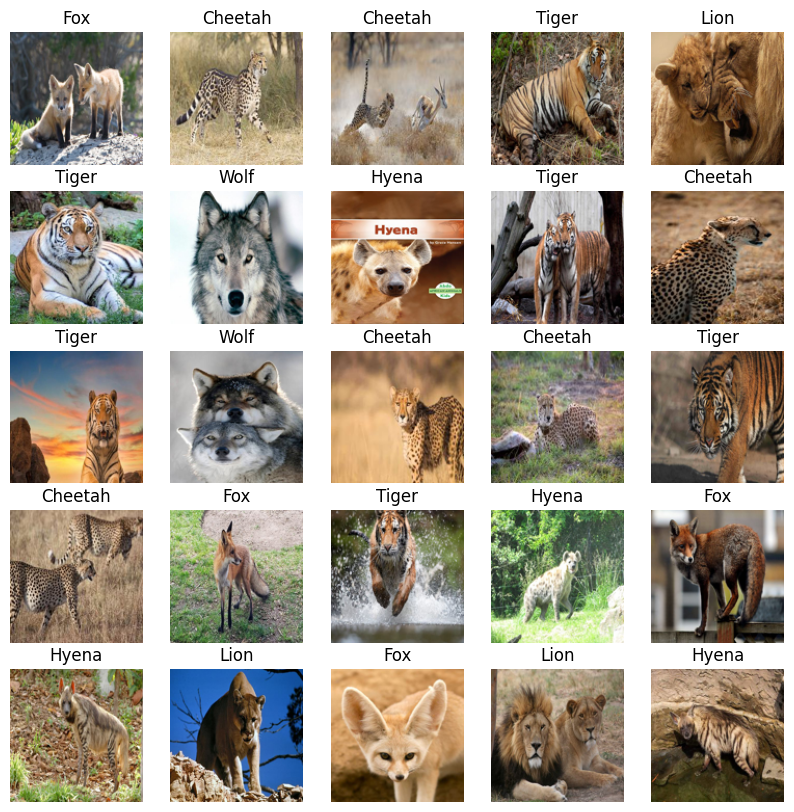

In [5]:
label_map = {0: 'Cheetah', 1: 'Fox', 2: 'Hyena', 3: 'Lion', 4: 'Tiger', 5: 'Wolf'}

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    index = random.randint(0, len(X_train)-1)
    label = y_train[index]
    ax.imshow(X_train[index])
    ax.set_title(label_map[label])
    ax.axis('off')
plt.show()

### How many classes and how many images per class?

In [6]:
print('I have', np.count_nonzero(y_train == 0), 'images of' , label_map[0] + 's',
      '\n''I have', np.count_nonzero(y_train == 1), 'images of' , label_map[1] + 's',
      '\n''I have', np.count_nonzero(y_train == 2), 'images of' , label_map[2] + 's',
      '\n''I have', np.count_nonzero(y_train == 3), 'images of' , label_map[3] + 's',
      '\n''I have', np.count_nonzero(y_train == 4), 'images of' , label_map[4] + 's',
      '\n''I have', np.count_nonzero(y_train == 5), 'images of' , label_map[5] + 's',
)

I have 319 images of Cheetahs 
I have 250 images of Foxs 
I have 305 images of Hyenas 
I have 294 images of Lions 
I have 269 images of Tigers 
I have 263 images of Wolfs


I have 6 different classes


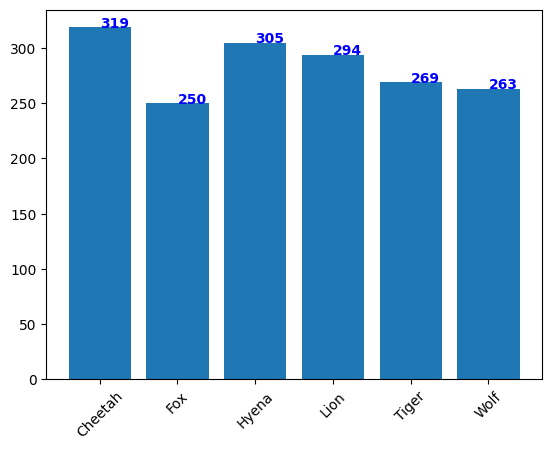

In [7]:
print('I have', len(np.unique(y_train)), 'different classes')

# Make a bar plot of the number of images per class.
plt.bar(label_map.values(), np.bincount(y_train))
plt.xticks(rotation=45)

#Add annotations to the bars
for i, v in enumerate(np.bincount(y_train)):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
    
plt.show()

### The size of my images

In [8]:
print(X_train.shape) # Size of the dataset
print("As you can see, I have", str(y_train.shape), "images of wild life animals, which are in", str(np.array(im_resized).shape), "pixels.")

(1700, 128, 128, 3)
As you can see, I have (1700,) images of wild life animals, which are in (128, 128, 3) pixels.


In [9]:
X_train.shape

(1700, 128, 128, 3)

In [10]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [11]:
print(X_train.shape,
        X_test.shape)

(1360, 128, 128, 3) (340, 128, 128, 3)


In [12]:
# Splitting the dataset into train and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5, 
                                                    random_state=42)

In [13]:
print(X_train.shape,
      X_val.shape,
      X_test.shape)

(1360, 128, 128, 3) (170, 128, 128, 3) (170, 128, 128, 3)


In [14]:
# Dividing the values by 255 to normalize the data and have values between 0 and 1
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

## 2) Baselines

- Random guess accuracy?
  - Since I have 6 classes, the random guess accuracy is 1/6 = 16.67%

- Human-Level Performance accuracy?
  - A total of 19 people were asked to classify the images. The average score was 98.4%.
  - [HLP](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-MaxMeiners/blob/main/Assignments/HLP%20Wildlife(1-19).xlsx)

- Multilayer Perceptron accuracy?
  - [MLP](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-MaxMeiners/blob/main/Deliverables/W2-DL1-MLP-Student-Notebook.ipynb)
  - [MLP with visualizations of learning curves, training and validation loss, and training and validation accuracy](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-MaxMeiners/blob/main/Deliverables/W2-DL2-MLP-Student-Notebook.ipynb)

## 3) Preprocessing

Explain all the preprocessing steps you did.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2)

data_generator = datagen.flow(X_train, y_train, batch_size=32)

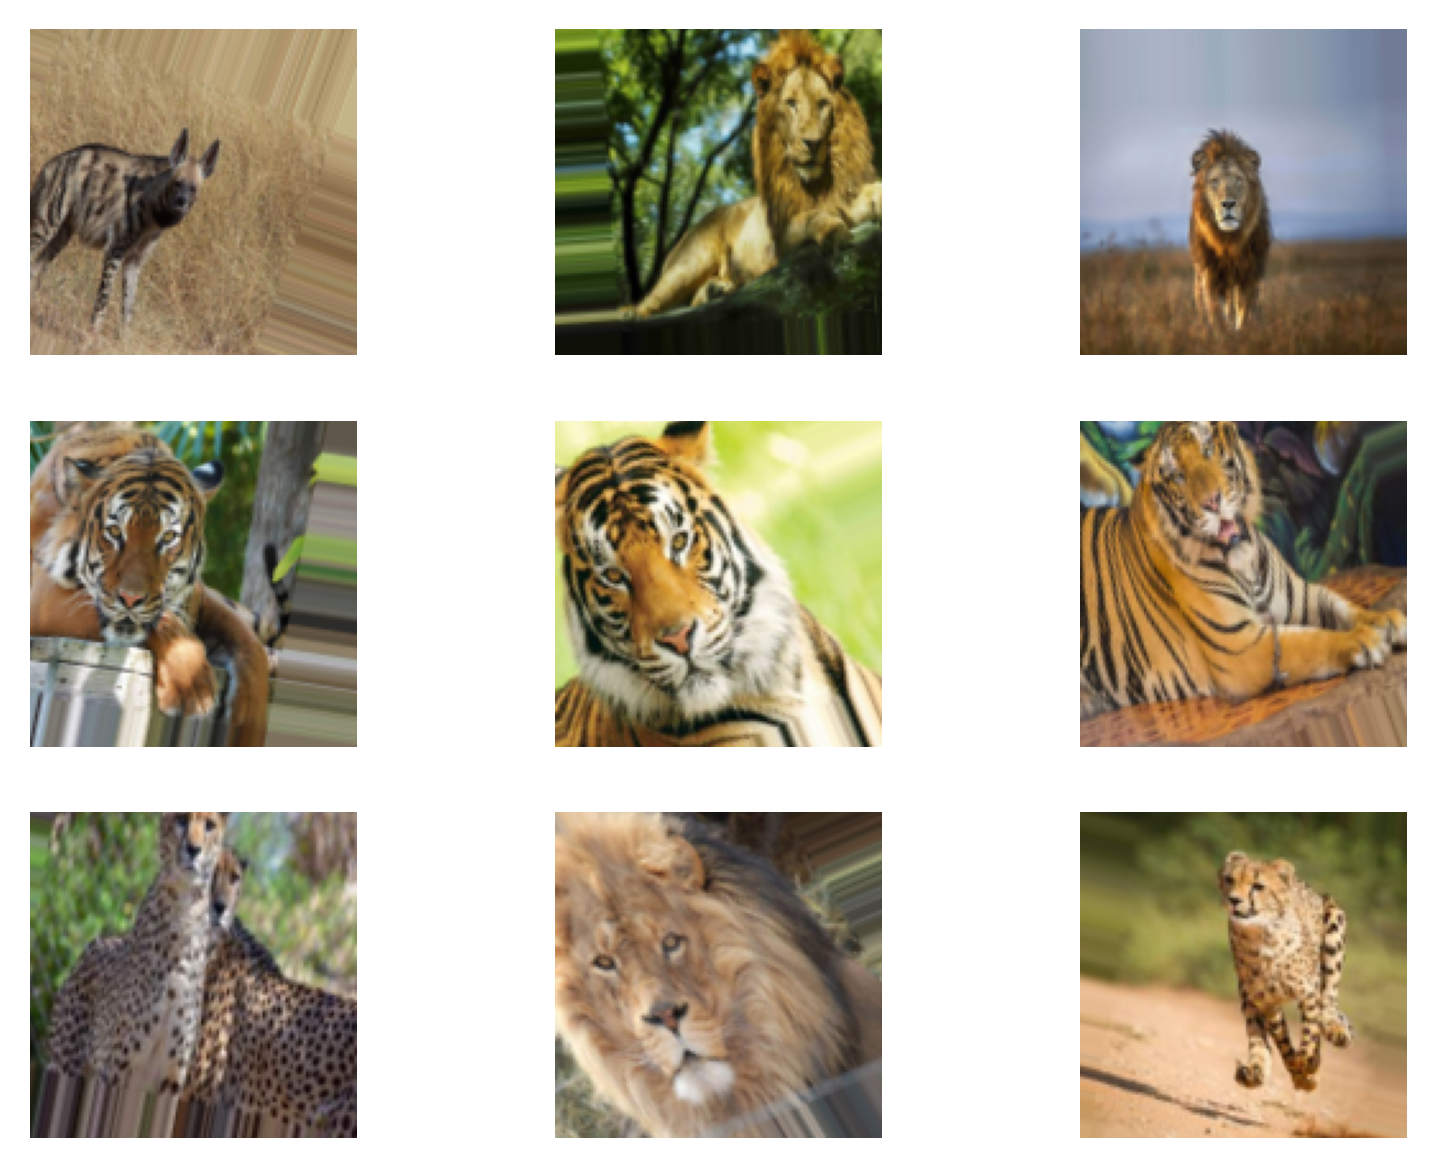

In [16]:
f, ax = plt.subplots(3, 3, dpi=300)

counter = 0
for batch in datagen.flow(X_train, batch_size=1):
    i = int((counter-counter%3)/3)
    j = counter%3
    
    ax[i, j].imshow(batch[0], cmap='gray')
    ax[i, j].axis('off')
    
    counter += 1
    if counter==9:break

## 4) CNN architecture

In [17]:
def build_model(print_summary=False):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(128, 128, 3)))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    if print_summary:
        model.summary()
    return model

model = build_model(print_summary=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

## 5) CNN training

- Loss function

- Optimizer (with its hyper-parameters)

- Metrics

- Learning curves

In [18]:
# Compiling the model
def compile_model(model, learning_rate):
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = compile_model(model, learning_rate=0.001)

In [19]:
# Early stopping callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

In [20]:
#Fitting the model
H = model.fit(data_generator, 
              epochs=100, 
              validation_data=(X_val, y_val),
              callbacks=early_stop)

Epoch 1/100
43/43 [==============================] - 7s 84ms/step - loss: 1.7918 - accuracy: 0.2015 - val_loss: 1.7531 - val_accuracy: 0.2235
Epoch 2/100
43/43 [==============================] - 3s 68ms/step - loss: 1.7215 - accuracy: 0.2559 - val_loss: 1.6961 - val_accuracy: 0.2941
Epoch 3/100
43/43 [==============================] - 3s 70ms/step - loss: 1.6565 - accuracy: 0.3029 - val_loss: 1.7678 - val_accuracy: 0.2765
Epoch 4/100
43/43 [==============================] - 3s 69ms/step - loss: 1.6580 - accuracy: 0.3096 - val_loss: 1.5317 - val_accuracy: 0.3941
Epoch 5/100
43/43 [==============================] - 4s 98ms/step - loss: 1.6077 - accuracy: 0.3346 - val_loss: 1.5339 - val_accuracy: 0.4059
Epoch 6/100
43/43 [==============================] - 4s 81ms/step - loss: 1.5656 - accuracy: 0.3691 - val_loss: 1.6443 - val_accuracy: 0.3294
Epoch 7/100
43/43 [==============================] - 5s 116ms/step - loss: 1.5013 - accuracy: 0.4081 - val_loss: 1.3826 - val_accuracy: 0.4412
Epoch

In [21]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print('Validation loss:', val_loss,
      '\n''Validation accuracy:', val_acc)

6/6 [==============================] - 0s 7ms/step - loss: 1.3530 - accuracy: 0.5471
Validation loss: 1.3529860973358154 
Validation accuracy: 0.5470588207244873


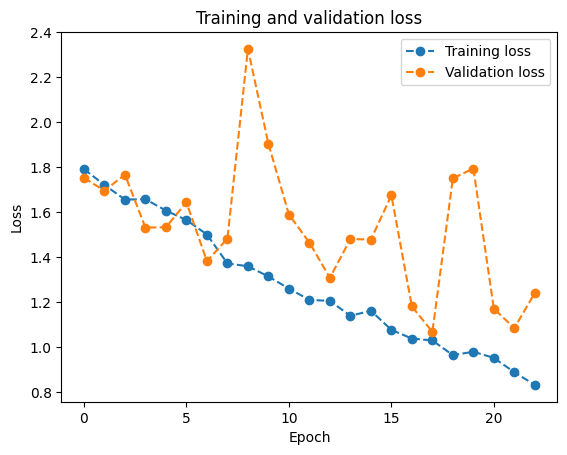

In [22]:
def loss_plotter(H):
    plt.plot(H.history['loss'], label='Training loss', linestyle='--', marker='o')
    plt.plot(H.history['val_loss'], label='Validation loss', linestyle='--',  marker='o')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

loss_plotter(H)

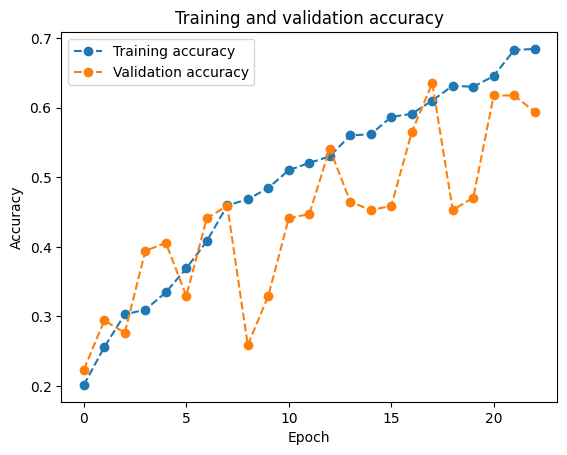

In [23]:
def accuracy_plotter(H):
    plt.plot(H.history['accuracy'], label='Training accuracy', linestyle='--', marker='o')
    plt.plot(H.history['val_accuracy'], label='Validation accuracy', linestyle='--',  marker='o')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

accuracy_plotter(H)